In [1]:
import os
# import drjit
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import pickle
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

## Weight Grid

This is the training code and display code for the unmitigated weight grid

In [2]:
# model_parameters = {}
# jammer_parameters = {}
# model_parameters["perfect_csi"] = False
# model_parameters["jammer_present"] = True
# model_parameters["num_silent_pilot_symbols"] = 0
# jammer_parameters["trainable"] = True
# model_parameters["jammer_parameters"] = jammer_parameters
# jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
# 
# sim.BATCH_SIZE = 2
# 
# # massive grid: training with different jammer power and different number of UEs
# num_ut = range(1, 9)
# jammer_power = [db_to_linear(x) for x in np.arange(-2.5, 15.1, 2.5, dtype=np.float32)]
# parameters = [(x, y) for x in num_ut for y in jammer_power]
# n, p = parameters[parameter_num]
# model_parameters["num_ut"] = n
# model_parameters["jammer_power"] = p
# model_parameters["num_ofdm_symbols"] = 14
# model_parameters["fft_size"] = 64
# model_parameters["num_bs_ant"] = 24
# jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
# model = Model(**model_parameters)
# train_model(model,
#             loss_fn=negative_function(MeanAbsoluteError()),
#             loss_over_logits=False,
#             weights_filename=f"weights/unmitigated/grid/ue_{n}_power_{linear_to_db(p):.1f}dB.pickle",
#             log_tensorboard=True,
#             log_weight_images=True,
#             show_final_weights=False,
#             num_iterations=2000,
#             ebno_db=2.5)

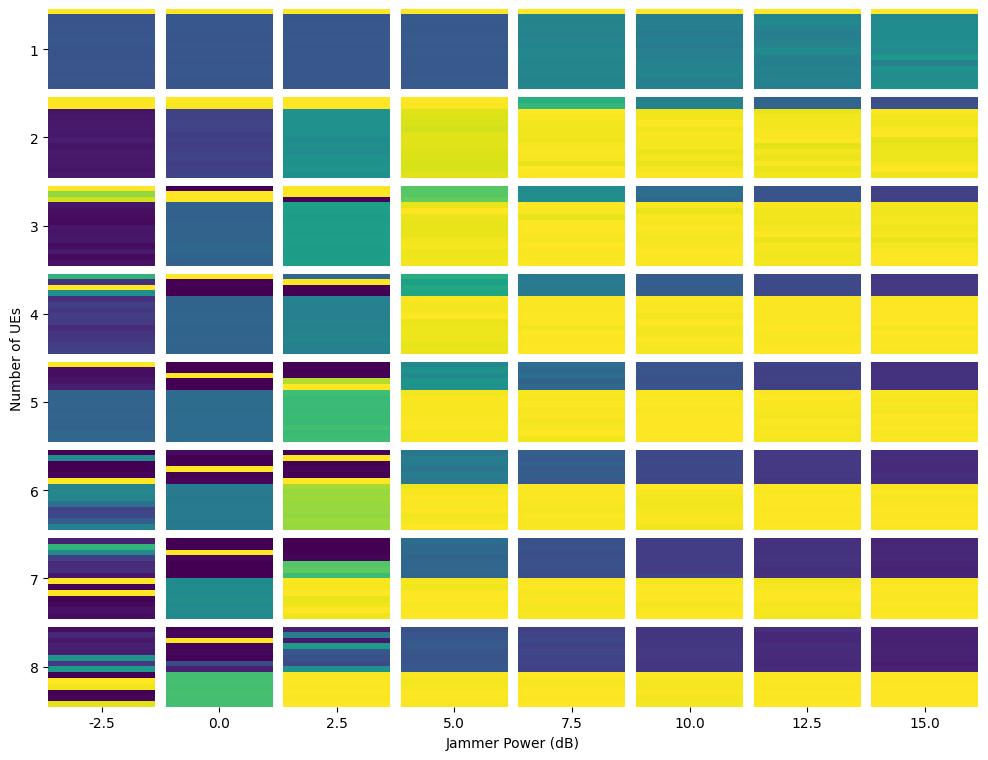

In [3]:
plt.figure(figsize=(10, 7.5))
num_ut = range(1, 9)
jammer_power = np.arange(-2.5, 15.1, 2.5, dtype=np.float32)
bers = np.zeros([len(num_ut), len(jammer_power)])
for i in range(len(num_ut)):
    for j in range(len(jammer_power)):
        n = num_ut[i]
        p = jammer_power[j]
        filename = f"weights/unmitigated/grid/ue_{n}_power_{p}dB.pickle"
        with open(filename, 'rb') as f:
            weights = pickle.load(f)[1]
        weights = NonNegMaxMeanSquareNorm()(weights)
        plt.subplot(len(num_ut), len(jammer_power), i * len(jammer_power) + j + 1)
        plt.axis('off')
        # plt.imshow(weights, aspect='auto')
        plt.imshow(weights, aspect='auto', vmin=0)

# parameters: space between plots
wspace = 0.1
hspace = 0.1
m = len(num_ut)
n = len(jammer_power)
plt.subplots_adjust(bottom=0.07, top=1.0, left=0.07, right=1.0, wspace=wspace, hspace=hspace)
# labels on the x and y plots-axis
ax = plt.gcf().add_axes([0.07, 0.07, 0.93, 0.93], frameon=False)
plot_width = 1.0 / (n + (n - 1) * wspace)
gap_width = wspace * plot_width
ax.set_xticks(np.arange(plot_width / 2, 1.0, gap_width + plot_width), labels=jammer_power)
ax.set_xlabel("Jammer Power (dB)")
ax.invert_yaxis()
plot_height = 1.0 / (m + (m - 1) * hspace)
gap_height = hspace * plot_height
ax.set_yticks(plot_height / 2 + np.arange(m) * (gap_height + plot_height), labels=num_ut)
ax.set_ylabel("Number of UEs")

plt.show()

## Simple Jammer Result

First demonstration: Unjammed vs Jammed(unmitigated) vs Jammed(POS)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.8737e-04 | 4.0208e-01 |         238 |      614400 |          193 |         480 |         1.7 |reached max iter       
   -2.778 | 1.1393e-05 | 1.4583e-02 |           7 |      614400 |            7 |         480 |         1.7 |reached max iter       
   -0.556 | 0.0000e+00 | 0.0000e+00 |           0 |      614400 |            0 |         480 |         1.7 |reached max iter       

Simulation stopped as no error occurred @ EbNo = -0.6 dB.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.3717e-02 | 9.9583e-0

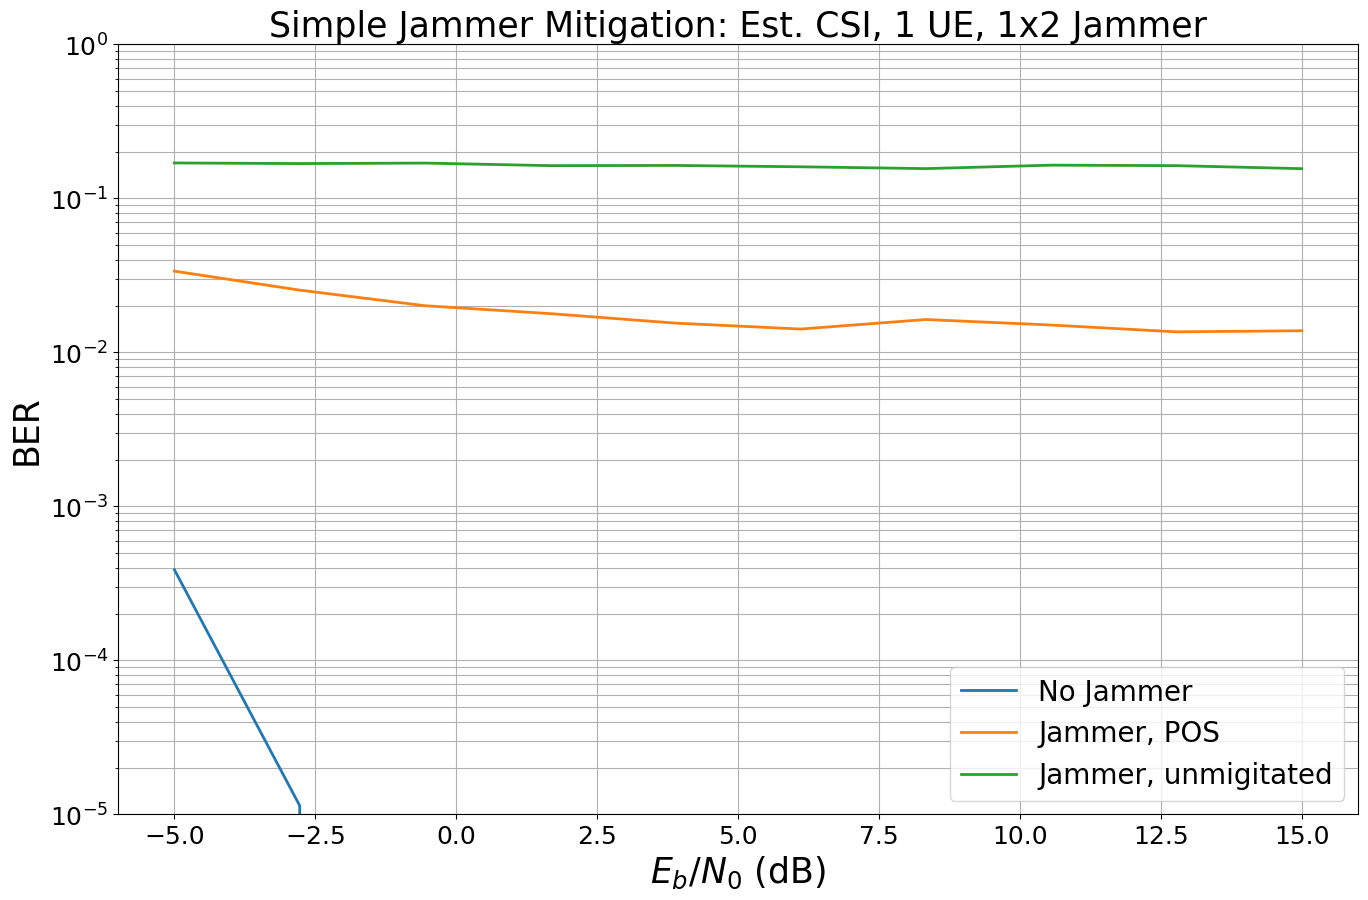

In [3]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = True
model_parameters["num_silent_pilot_symbols"] = 8
jammer_parameters["num_tx"] = 2
jammer_parameters["num_tx_ant"] = 1
jammer_parameters["normalize_channel"] = True
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["scenario"] = "rayleigh"
# sim.BATCH_SIZE = 256
# sim.MAX_MC_ITER = 20
sim.BATCH_SIZE = 16
sim.MAX_MC_ITER = 30
# sim.MAX_MC_ITER = 1000
# sim.ebno_dbs = np.linspace(-5., 15., 21)
sim.ebno_dbs = np.linspace(-5., 15., 10)

ber_plots.reset()
model = Model(**model_parameters)
simulate_model(model, "No Jammer")

model_parameters["perfect_jammer_csi"] = False
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = None
model = Model(**model_parameters)
simulate_model(model, "Jammer, POS")

model_parameters["jammer_mitigation"] = None
model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated")

ber_plots.title = "Simple Jammer Mitigation: Est. CSI, 1 UE, 1x2 Jammer"
ber_plots(ylim=(1e-5, 1))
    # with open("bers/simple_pos.pickle", 'rb') as f:
    #     bers = pickle.dump(ber_plots, f)

Now we add some velocity (0km/h, 20km/h, 120km/h). Compared with unmitigated jammer.

In [ ]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["num_tx_ant"] = 2
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(5.)
sim.BATCH_SIZE = 256
# sim.MAX_MC_ITER = 1000
sim.MAX_MC_ITER = 30
# sim.ebno_dbs = np.linspace(-5., 15., 21)
sim.ebno_dbs = np.linspace(-5., 15., 10)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 2
kmhs = [0, 20, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    model_parameters["min_ut_velocity"] = meter_per_second
    model_parameters["max_ut_velocity"] = meter_per_second
    model_parameters["min_jammer_velocity"] = meter_per_second
    model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "Jammers with velocity: Est. CSI, 1 UE, 1x2 Jammer (5dB/Ant)"
ber_plots(ylim=(1e-5, 1))
# with open("bers/simple_pos.pickle", 'rb') as f:
#     bers = pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.1465e-01 | 1.0000e+00 |     7337140 |    17694720 |         7680 |        7680 |        16.6 |reached max iter       
   -2.778 | 4.1347e-01 | 1.0000e+00 |     7316268 |    17694720 |         7680 |        7680 |         7.4 |reached max iter       
   -0.556 | 4.1251e-01 | 1.0000e+00 |     7299309 |    17694720 |         7680 |        7680 |         7.4 |reached max iter       


## Time Domain Simulation

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7994e-03 | 9.9500e-01 |        7003 |     1843200 |          796 |         800 |        13.5 |reached max iter       
   -2.778 | 6.2066e-04 | 4.9375e-01 |        1144 |     1843200 |          395 |         800 |         4.2 |reached max iter       
   -0.556 | 7.0530e-05 | 9.2500e-02 |         130 |     1843200 |           74 |         800 |         4.2 |reached max iter       
    1.667 | 6.5104e-06 | 1.2500e-02 |          12 |     1843200 |           10 |         800 |         4.2 |reached max iter       
    3.889 | 0.0000e+00 | 0.0000e+00 |           0 |     1843200 |            0 |         800 |         4.2 |reached max iter       

Simulation stopped as no error occurred @ EbNo = 3.9 dB.

EbNo [dB] |        BER |  

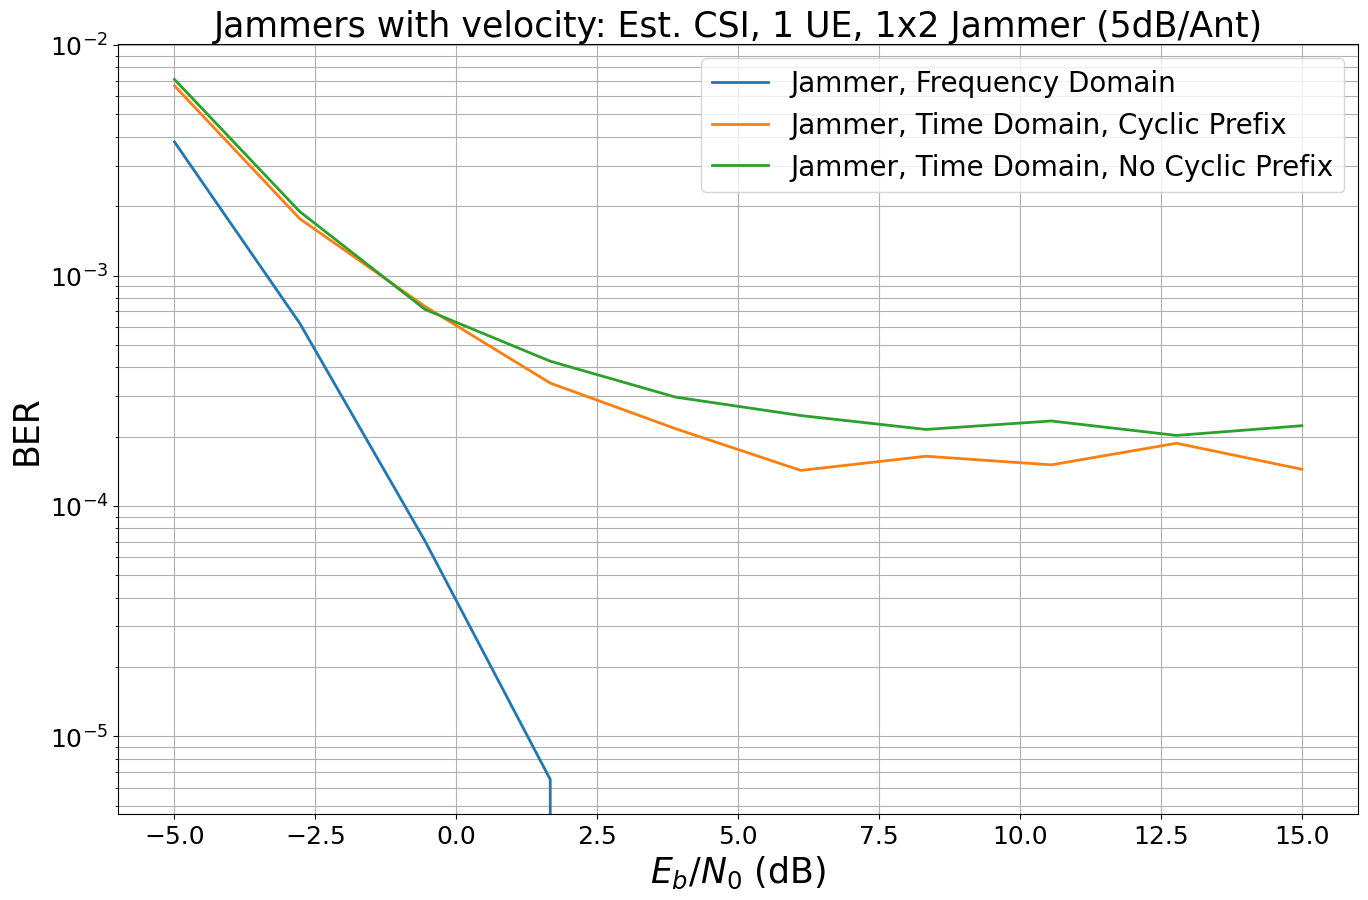

In [ ]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = True
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = linear_to_db(25.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
sim.BATCH_SIZE = 16
sim.MAX_MC_ITER = 50
sim.ebno_dbs = np.linspace(-5., 15., 10)
# sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

jammer_parameters["send_cyclic_prefix"] = False
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots()